In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Install all functions here

In [ ]:
! pip install rdkit requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 20.2 MB/s eta 0:00:00


All imports will go here

In [ ]:
import pandas as pd
import pandas as pd
import requests
import time
from rdkit import Chem
import json

Load the Raw data

In [ ]:
dataDir = '/content/drive/Shareddrives/GCCP/GCCP/Raw_data_files/'
outputDir = '/content/drive/Shareddrives/GCCP/GCCP/Output_files/'
modelBuildingDataDir = '/content/drive/Shareddrives/GCCP/GCCP/Data_Model_Building/'
modelBuildingDataDirPublished = '/content/drive/Shareddrives/GCCP/GCCP/Data_for_Model_Building/'

In [ ]:

JRGC_Data_dF = pd.read_csv(dataDir+'JRGC_Data_cleaned.csv')
JRGC_Data_dF.shape

(3459, 9)

In [ ]:
Hvap_CRC_dF = pd.read_csv(modelBuildingDataDir+'Hvap_prediction_data_fcl_with_N.csv')
Pc_CRC_dF = pd.read_csv(modelBuildingDataDir+'Pc_prediction_data_fcl_with_N.csv')
Vc_CRC_dF = pd.read_csv(modelBuildingDataDir+'Vc_prediction_data_fcl_with_N.csv')
Tc_CRC_dF = pd.read_csv(modelBuildingDataDir+'Tc_prediction_data_fcl_with_N.csv')
Tb_CRC_dF = pd.read_csv(modelBuildingDataDir+'Tb_prediction_data_fcl_with_N.csv')
Tm_CRC_dF = pd.read_csv(modelBuildingDataDir+'Tm_prediction_data_fcl_with_N.csv')
logP_CRC_dF = pd.read_csv(modelBuildingDataDir+'logP_prediction_data_fcl_with_N.csv')

In [ ]:
modified_Tb_CRC_dF = Tb_CRC_dF[Tb_CRC_dF['PubChem SMILES'].isin(JRGC_Data_dF['SMILES'])]
modified_Tb_CRC_dF.shape

(964, 5)

In [ ]:
modified_Tm_CRC_dF = Tm_CRC_dF[Tm_CRC_dF['PubChem SMILES'].isin(JRGC_Data_dF['SMILES'])]
modified_Tm_CRC_dF.shape

(1932, 5)

In [ ]:
modified_Pc_CRC_dF = Pc_CRC_dF[Pc_CRC_dF['PubChem SMILES'].isin(JRGC_Data_dF['SMILES'])]
modified_Pc_CRC_dF.shape

(73, 5)

In [ ]:
modified_Vc_CRC_dF = Vc_CRC_dF[Vc_CRC_dF['PubChem SMILES'].isin(JRGC_Data_dF['SMILES'])]
modified_Vc_CRC_dF.shape

(69, 5)

In [ ]:
modified_Tc_CRC_dF = Tc_CRC_dF[Tc_CRC_dF['PubChem SMILES'].isin(JRGC_Data_dF['SMILES'])]
modified_Tc_CRC_dF.shape

(73, 5)

In [ ]:
# Filter Hvap_CRC_dF to keep only rows where 'PubChem SMILES' matches 'SMILES' in JRGC_Data_dF
modified_Hvap_CRC_dF = Hvap_CRC_dF[Hvap_CRC_dF['PubChem SMILES'].isin(JRGC_Data_dF['SMILES'])]
modified_Hvap_CRC_dF.shape

(75, 5)

In [ ]:
modified_logP_CRC_dF = logP_CRC_dF[logP_CRC_dF['PubChem SMILES'].isin(JRGC_Data_dF['SMILES'])]
modified_logP_CRC_dF.shape

(3463, 5)

**### Now using train and test for 1:1 comparison of GPGC predicted data** from the Joback-Reid Group Contribution (JR-GC) method with experimental data from chemical databases (CRC)

The framework evaluates three critical thermophysical properties:
- Molecular Weight (g/mol)
- Boiling Point (K)
- Melting Point (K)
- Critical temperature (Tc)
- Critical pressure (Pc)
- Critical volume (Vc)
- Enthalpy of vaporistaion (H_vap)

### Boiling Point Comparison [JR-predictions vs Experimental (CRC handbook)]

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from datetime import datetime

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


def parsePropertyInfo(predicted_col, experimental_col):
    """Extract property name and unit from column headers"""
    pred_parts = predicted_col.split()
    exp_parts = experimental_col.split()

    pred_method = pred_parts[0] if len(pred_parts) > 0 else "Predicted"
    exp_method = exp_parts[0] if len(exp_parts) > 0 else "Experimental"

    if len(pred_parts) >= 2:
        property_name = pred_parts[1]
    else:
        property_name = "Property"

    pred_unit = ""
    exp_unit = ""

    for part in pred_parts:
        if "/" in part:
            pred_unit = part.split("/")[-1]
            break

    for part in exp_parts:
        if "/" in part:
            exp_unit = part.split("/")[-1]
            break

    unit = exp_unit if exp_unit else pred_unit
    property_name_clean = property_name.replace("_", " ").title()

    return {
        'property_name': property_name_clean,
        'unit': unit,
        'pred_method': pred_method,
        'exp_method': exp_method,
        'full_property_name': f"{property_name_clean} ({unit})" if unit else property_name_clean
    }


def splitData(dataFrame, test_size=0.2, random_state=42, experimental_col=None):
    """Split data into train and test sets"""
    if experimental_col is None:
        experimental_col = dataFrame.columns[-1]

    valid_data = dataFrame[dataFrame[experimental_col].notna()].copy()

    train_data, test_data = train_test_split(
        valid_data,
        test_size=test_size,
        random_state=random_state,
        stratify=None
    )

    print(f"Data split completed:")
    print(f"Total valid samples: {len(valid_data)}")
    print(f"Training samples: {len(train_data)} ({len(train_data)/len(valid_data)*100:.1f}%)")
    print(f"Test samples: {len(test_data)} ({len(test_data)/len(valid_data)*100:.1f}%)")
    print("-" * 50)

    return train_data, test_data


def trainModel(train_data, feature_columns, target_column):
    """Placeholder for model training function"""
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler

    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_train = X_train.fillna(X_train.mean())

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    print(f"Model trained on {len(X_train)} samples")
    print(f"Features used: {feature_columns}")

    return model, scaler


def predictOnTest(model, scaler, test_data, feature_columns, target_column):
    """Make predictions on test set"""
    X_test = test_data[feature_columns]
    y_test = test_data[target_column]
    X_test = X_test.fillna(X_test.mean())

    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    test_data_with_pred = test_data.copy()
    test_data_with_pred['Predicted_' + target_column] = y_pred

    return test_data_with_pred


def identifyStatisticalOutliers(dataFrame, experimental_col, predicted_col, errorPercentileThreshold=95):
    """Identify statistical outliers based on relative error"""
    relativeError = np.abs((dataFrame[experimental_col] - dataFrame[predicted_col]) /
                          dataFrame[experimental_col]) * 100
    relativeError.index = dataFrame.index

    errorThreshold = np.percentile(relativeError.dropna(), errorPercentileThreshold)
    outlierMask = relativeError > errorThreshold

    return outlierMask, relativeError


def calculateStatistics(exp_data, pred_data):
    """Calculate statistical metrics"""
    mae = mean_absolute_error(exp_data, pred_data)
    rmse = np.sqrt(mean_squared_error(exp_data, pred_data))
    mape = np.mean(np.abs((exp_data - pred_data) / exp_data)) * 100
    r2 = r2_score(exp_data, pred_data)

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}


def saveStatisticsToCSV(property_name, unit, stats_train, stats_test,
                        n_train, n_test, n_outliers_train, n_outliers_test,
                        outputDir, filename='statistical_comparison.csv'):
    """Save statistical comparison to a CSV file"""
    os.makedirs(outputDir, exist_ok=True)
    filepath = os.path.join(outputDir, filename)

    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    data_row = {
        'Timestamp': timestamp,
        'Property': property_name,
        'Unit': unit,

        # Train metrics
        'N_Train': n_train,
        'N_Outliers_Train': n_outliers_train,
        'Outlier_Percentage_Train': (n_outliers_train / n_train * 100) if n_train > 0 else 0,
        'R2_Train': stats_train['R2'],
        'MAE_Train': stats_train['MAE'],
        'RMSE_Train': stats_train['RMSE'],
        'MAPE_Train': stats_train['MAPE'],

        # Test metrics
        'N_Test': n_test,
        'N_Outliers_Test': n_outliers_test,
        'Outlier_Percentage_Test': (n_outliers_test / n_test * 100) if n_test > 0 else 0,
        'R2_Test': stats_test['R2'],
        'MAE_Test': stats_test['MAE'],
        'RMSE_Test': stats_test['RMSE'],
        'MAPE_Test': stats_test['MAPE'],

        # Differences
        'R2_Diff': stats_train['R2'] - stats_test['R2'],
        'MAE_Diff': stats_test['MAE'] - stats_train['MAE'],
        'RMSE_Diff': stats_test['RMSE'] - stats_train['RMSE'],
    }

    new_data = pd.DataFrame([data_row])

    if os.path.exists(filepath):
        existing_data = pd.read_csv(filepath)
        combined_data = pd.concat([existing_data, new_data], ignore_index=True)
        combined_data.to_csv(filepath, index=False)
        print(f"Statistics appended to: {filepath}")
    else:
        new_data.to_csv(filepath, index=False)
        print(f"New statistics file created: {filepath}")

    return filepath


def plotCombinedTrainTest(train_df, test_df, property_name=None, unit=None,
                         x_label=None, y_label=None, plot_title=None,
                         outputDir=None, save_plot=True):
    """
    Plot train and test data together in one plot (matching the desired style)

    Parameters:
    -----------
    train_df : pd.DataFrame
        Training data with predicted (second-to-last) and experimental (last) columns
    test_df : pd.DataFrame
        Test data with predicted (second-to-last) and experimental (last) columns
    property_name : str
        Property name (for file naming)
    unit : str
        Unit of measurement (for CSV statistics)
    x_label : str
        Custom x-axis label
    y_label : str
        Custom y-axis label
    plot_title : str
        Custom plot title
    outputDir : str
        Directory to save plot
    save_plot : bool
        Whether to save the plot
    """

    # Get column names
    columns = train_df.columns.tolist()
    predicted_col = columns[-2]
    experimental_col = columns[-1]

    # Parse property info (for file naming only)
    prop_info = parsePropertyInfo(predicted_col, experimental_col)
    if property_name:
        prop_info['property_name'] = property_name
    if unit:
        prop_info['unit'] = unit

    print(f"Plotting Combined Train+Test: {prop_info['property_name']}")
    print("-" * 50)

    # Filter valid data
    train_valid = train_df[(train_df[experimental_col].notna() &
                           train_df[predicted_col].notna())].copy()
    test_valid = test_df[(test_df[experimental_col].notna() &
                         test_df[predicted_col].notna())].copy()

    if len(train_valid) == 0 or len(test_valid) == 0:
        print("Error: No valid data in train or test set")
        return None, None

    # Identify outliers
    train_outliers, _ = identifyStatisticalOutliers(train_valid, experimental_col, predicted_col)
    test_outliers, _ = identifyStatisticalOutliers(test_valid, experimental_col, predicted_col)

    # Extract values
    y_train_obs = train_valid[experimental_col].values
    y_train_pred = train_valid[predicted_col].values
    y_test_obs = test_valid[experimental_col].values
    y_test_pred = test_valid[predicted_col].values

    # Calculate metrics
    train_stats = calculateStatistics(y_train_obs, y_train_pred)
    test_stats = calculateStatistics(y_test_obs, y_test_pred)

    # Create plot
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot train data (blue)
    ax.scatter(y_train_obs, y_train_pred, alpha=1, s=20, color='blue',
              label='Train', edgecolors='blue', linewidth=0.2)

    # Plot test data (red)
    ax.scatter(y_test_obs, y_test_pred, alpha=1, s=20, color='red',
              label='Test', edgecolors='red', linewidth=0.2)

    # Perfect prediction line
    all_vals = np.concatenate([y_train_obs, y_test_obs, y_train_pred, y_test_pred])
    lim = [all_vals.min(), all_vals.max()]
    ax.plot(lim, lim, 'k--', lw=1, alpha=0.7)

    # Use custom labels or default ones
    if x_label is None:
        x_label = f'Experimental {prop_info["property_name"]} ({prop_info["unit"]})'
    if y_label is None:
        y_label = f'Predicted {prop_info["property_name"]} ({prop_info["unit"]})'
    if plot_title is None:
        plot_title = f'{prop_info["property_name"]} Predictions'

    # Set labels and title
    ax.set_xlabel(x_label, fontsize=10, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=10, fontweight='bold')
    ax.set_title(plot_title, fontsize=10, fontweight='bold', pad=10)

    # Train metrics box (top-left, blue text)
    ax.text(0.02, 0.98,
           f'$R^2_{{\\mathrm{{Train}}}} = {train_stats["R2"]:.2f}$\n'
           f'$\\mathrm{{MAE}}_{{\\mathrm{{Train}}}} = {train_stats["MAE"]:.2f}$\n'
           f'$\\mathrm{{RMSE}}_{{\\mathrm{{Train}}}} = {train_stats["RMSE"]:.2f}$',
           transform=ax.transAxes, fontsize=8, va='top', ha='left',
           color='blue')

    # Test metrics box (bottom-right, red text)
    ax.text(0.98, 0.02,
           f'$R^2_{{\\mathrm{{Test}}}} = {test_stats["R2"]:.2f}$\n'
           f'$\\mathrm{{MAE}}_{{\\mathrm{{Test}}}} = {test_stats["MAE"]:.2f}$\n'
           f'$\\mathrm{{RMSE}}_{{\\mathrm{{Test}}}} = {test_stats["RMSE"]:.2f}$',
           transform=ax.transAxes, fontsize=8, va='bottom', ha='right',
           color='red')

    plt.tight_layout()

    # Save plot
    if save_plot and outputDir:
        os.makedirs(outputDir, exist_ok=True)
        property_clean = prop_info['property_name'].replace(' ', '_').replace('/', '_')
        save_path = os.path.join(outputDir, f'parity_plot_{property_clean}_combined')
        plt.savefig(f'{save_path}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{save_path}.svg', bbox_inches='tight')
        print(f"Plot saved to: {save_path}.png and {save_path}.svg")

    plt.show()
    plt.close()

    # Print statistics comparison
    print(f"\nStatistical Comparison:")
    print("="*70)
    print(f"{'Metric':<15} {'Train':<15} {'Test':<15} {'Difference':<15}")
    print("-"*70)
    for metric in ['R2', 'MAE', 'RMSE', 'MAPE']:
        train_val = train_stats[metric]
        test_val = test_stats[metric]
        if metric == 'R2':
            diff = train_val - test_val
        else:
            diff = test_val - train_val
        print(f"{metric:<15} {train_val:<15.4f} {test_val:<15.4f} {diff:+15.4f}")

    print(f"\nOutliers identified:")
    print(f"Train: {train_outliers.sum()} ({train_outliers.sum()/len(train_valid)*100:.1f}%)")
    print(f"Test: {test_outliers.sum()} ({test_outliers.sum()/len(test_valid)*100:.1f}%)")

    # Save statistics to CSV
    if outputDir:
        saveStatisticsToCSV(
            property_name=prop_info['property_name'],
            unit=prop_info['unit'],
            stats_train=train_stats,
            stats_test=test_stats,
            n_train=len(y_train_obs),
            n_test=len(y_test_obs),
            n_outliers_train=train_outliers.sum(),
            n_outliers_test=test_outliers.sum(),
            outputDir=outputDir
        )

    return train_stats, test_stats


def runCompleteTrainTestAnalysis(dataFrame, feature_columns, target_column,
                                test_size=0.2, random_state=42, property_description="",
                                x_label=None, y_label=None, plot_title=None,
                                outputDir='/content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/'):
    """
    Run complete train-test analysis workflow with combined plotting

    Parameters:
    -----------
    dataFrame : pd.DataFrame
        Input dataframe
    feature_columns : list
        List of feature column names
    target_column : str
        Target column name
    test_size : float
        Proportion of test set
    random_state : int
        Random seed
    property_description : str
        Description for console output
    x_label : str
        Custom x-axis label (if None, auto-generated)
    y_label : str
        Custom y-axis label (if None, auto-generated)
    plot_title : str
        Custom plot title (if None, auto-generated)
    outputDir : str
        Output directory path
    """

    print(f"Complete Train-Test Analysis: {property_description}")
    print("="*80)
    print(f"DataFrame shape: {dataFrame.shape}")
    print(f"Target column: {target_column}")
    print(f"Feature columns: {feature_columns}")
    print()

    # 1. Split the data
    train_data, test_data = splitData(dataFrame, test_size, random_state, target_column)

    # 2. Extract property name for file naming
    target_parts = target_column.split()
    if len(target_parts) >= 2:
        property_name = target_parts[1]
    else:
        property_name = target_column.replace(' ', '_').replace('/', '_')

    property_name_clean = property_name.replace('/', '_').replace(' ', '_')

    # Extract unit
    unit = ""
    for part in target_parts:
        if "/" in part:
            unit = part.split("/")[-1]
            break

    # 3. Save train and test datasets to CSV files
    try:
        os.makedirs(outputDir, exist_ok=True)

        train_file_path = os.path.join(outputDir, f'JRGC_train_{property_name_clean}.csv')
        test_file_path = os.path.join(outputDir, f'JRGC_test_{property_name_clean}.csv')

        train_data.to_csv(train_file_path, index=False)
        test_data.to_csv(test_file_path, index=False)

        print(f"Train dataset saved to: {train_file_path}")
        print(f"Test dataset saved to: {test_file_path}")
        print("-" * 50)

    except Exception as e:
        print(f"Warning: Could not save CSV files. Error: {e}")
        print("-" * 50)

    # 4. Train the model
    model, scaler = trainModel(train_data, feature_columns, target_column)

    # 5. Make predictions on both sets
    train_data_with_pred = predictOnTest(model, scaler, train_data, feature_columns, target_column)
    test_data_with_pred = predictOnTest(model, scaler, test_data, feature_columns, target_column)

    # 6. Prepare columns for analysis
    predicted_col = 'Predicted_' + target_column
    analysis_columns = test_data_with_pred.columns.tolist()

    # Reorder columns so predicted comes before experimental
    if predicted_col in analysis_columns and target_column in analysis_columns:
        analysis_columns.remove(predicted_col)
        analysis_columns.remove(target_column)
        analysis_columns.extend([predicted_col, target_column])

    train_analysis_df = train_data_with_pred[analysis_columns]
    test_analysis_df = test_data_with_pred[analysis_columns]

    # 7. Create combined plot with custom labels
    print("\n" + "="*80)
    print("GENERATING COMBINED TRAIN+TEST PLOT")
    print("="*80)

    train_stats, test_stats = plotCombinedTrainTest(
        train_df=train_analysis_df,
        test_df=test_analysis_df,
        property_name=property_name,
        unit=unit,
        x_label=x_label,
        y_label=y_label,
        plot_title=plot_title,
        outputDir=outputDir,
        save_plot=True
    )

    # 8. Print CSV file location
    stats_csv_path = os.path.join(outputDir, 'statistical_comparison.csv')
    if os.path.exists(stats_csv_path):
        print(f"\nStatistical comparison saved to: {stats_csv_path}")

    return {
        'model': model,
        'scaler': scaler,
        'train_data': train_data,
        'test_data': test_data,
        'train_results': train_data_with_pred,
        'test_results': test_data_with_pred,
        'train_stats': train_stats,
        'test_stats': test_stats,
        'file_paths': {
            'train_csv': train_file_path if 'train_file_path' in locals() else None,
            'test_csv': test_file_path if 'test_file_path' in locals() else None,
            'stats_csv': stats_csv_path if os.path.exists(stats_csv_path) else None
        }
    }




Complete Train-Test Analysis: Boiling Point Analysis
DataFrame shape: (964, 5)
Target column: CRC Tb /K
Feature columns: ['Mol. wt.', 'JR Tb /K']

Data split completed:
Total valid samples: 964
Training samples: 771 (80.0%)
Test samples: 193 (20.0%)
--------------------------------------------------
Train dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Tb.csv
Test dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Tb.csv
--------------------------------------------------
Model trained on 771 samples
Features used: ['Mol. wt.', 'JR Tb /K']

GENERATING COMBINED TRAIN+TEST PLOT
Plotting Combined Train+Test: Tb
--------------------------------------------------
Plot saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Tb_combined.png and /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Tb_combined.svg


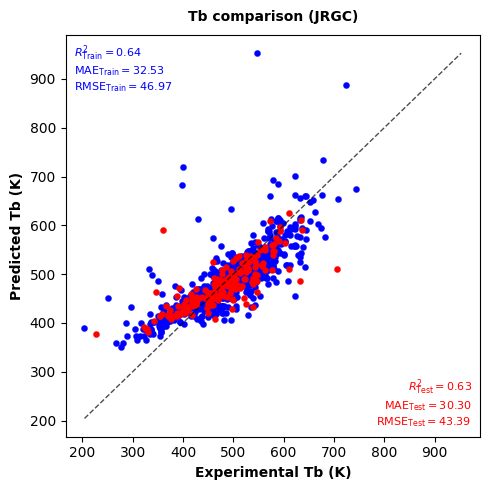


Statistical Comparison:
Metric          Train           Test            Difference     
----------------------------------------------------------------------
R2              0.6447          0.6348                  +0.0100
MAE             32.5271         30.2986                 -2.2285
RMSE            46.9742         43.3874                 -3.5868
MAPE            7.0866          6.7753                  -0.3113

Outliers identified:
Train: 39 (5.1%)
Test: 10 (5.2%)
Statistics appended to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Statistical comparison saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

SUMMARY
Train data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Tb.csv
Test data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Tb.csv
Statistics: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Train R²: 0.645
Test R²: 0.635

In [79]:
# Define your feature columns and target column
feature_columns = ['Mol. wt.', 'JR Tb /K']
target_column = 'CRC Tb /K'

# Run complete analysis with CUSTOM labels and title
results = runCompleteTrainTestAnalysis(
    dataFrame=modified_Tb_CRC_dF,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2,
    random_state=42,
    property_description="Boiling Point Analysis",

    # CUSTOM LABELS AND TITLE
    x_label='Experimental Tb (K)',
    y_label='Predicted Tb (K)',
    plot_title='Tb comparison (JRGC)',

    outputDir='/content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/'
)

# Access results
trained_model = results['model']
train_performance = results['train_stats']
test_performance = results['test_stats']

# Check saved file paths
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
if results['file_paths']['train_csv']:
    print(f"Train data: {results['file_paths']['train_csv']}")
if results['file_paths']['test_csv']:
    print(f"Test data: {results['file_paths']['test_csv']}")
if results['file_paths']['stats_csv']:
    print(f"Statistics: {results['file_paths']['stats_csv']}")

print(f"\nTrain R²: {train_performance['R2']:.3f}")
print(f"Test R²: {test_performance['R2']:.3f}")
print(f"Overfitting (ΔR²): {train_performance['R2'] - test_performance['R2']:+.3f}")

In [80]:
modified_Tb_CRC_dF.columns

Index(['CAS Reg. No.', 'PubChem SMILES', 'Mol. wt.', 'JR Tb /K', 'CRC Tb /K'], dtype='object')

Complete Train-Test Analysis: Your Property Analysis
DataFrame shape: (964, 5)
Target column: CRC Tb /K
Feature columns: ['Mol. wt.', 'JR Tb /K']

Data split completed:
Total valid samples: 964
Training samples: 771 (80.0%)
Test samples: 193 (20.0%)
--------------------------------------------------
Train dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Tb.csv
Test dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Tb.csv
--------------------------------------------------
Model trained on 771 samples
Features used: ['Mol. wt.', 'JR Tb /K']

GENERATING COMBINED TRAIN+TEST PLOT
Plotting Combined Train+Test: Tb
--------------------------------------------------
Plot saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Tb_combined.png and /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Tb_combined.svg


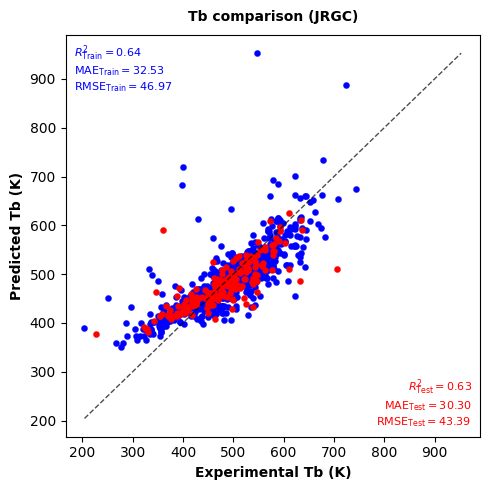


Statistical Comparison:
Metric          Train           Test            Difference     
----------------------------------------------------------------------
R2              0.6447          0.6348                  +0.0100
MAE             32.5271         30.2986                 -2.2285
RMSE            46.9742         43.3874                 -3.5868
MAPE            7.0866          6.7753                  -0.3113

Outliers identified:
Train: 39 (5.1%)
Test: 10 (5.2%)
Statistics appended to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Statistical comparison saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

SUMMARY
Train data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Tb.csv
Test data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Tb.csv
Statistics: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Train R²: 0.645
Test R²: 0.635

In [81]:
# Define your feature columns and target column
feature_columns = ['Mol. wt.', 'JR Tb /K']  # Replace with your actual feature column names
target_column = 'CRC Tb /K'  # Replace with your target property column name

# Run complete analysis
results = runCompleteTrainTestAnalysis(
    dataFrame=modified_Tb_CRC_dF,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2,
    random_state=42,
    property_description="Your Property Analysis",

    # CUSTOM LABELS AND TITLE
    x_label='Experimental Tb (K)',
    y_label='Predicted Tb (K)',
    plot_title='Tb comparison (JRGC)',

    outputDir='/content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/'
)

# Access results
trained_model = results['model']
train_performance = results['train_stats']
test_performance = results['test_stats']

# Check saved file paths
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
if results['file_paths']['train_csv']:
    print(f"Train data: {results['file_paths']['train_csv']}")
if results['file_paths']['test_csv']:
    print(f"Test data: {results['file_paths']['test_csv']}")
if results['file_paths']['stats_csv']:
    print(f"Statistics: {results['file_paths']['stats_csv']}")

print(f"\nTrain R²: {train_performance['R2']:.3f}")
print(f"Test R²: {test_performance['R2']:.3f}")
print(f"Overfitting (ΔR²): {train_performance['R2'] - test_performance['R2']:+.3f}")

### Melting Point Comparison [JR-predictions vs Experimental (CRC handbook)]

In [82]:
modified_Tm_CRC_dF.columns

Index(['CAS Reg. No.', 'PubChem SMILES', 'Mol. wt.', 'JR Tm /K', 'CRC Tm /K'], dtype='object')

Complete Train-Test Analysis: Your Property Analysis
DataFrame shape: (1932, 5)
Target column: CRC Tm /K
Feature columns: ['Mol. wt.', 'JR Tm /K']

Data split completed:
Total valid samples: 1932
Training samples: 1545 (80.0%)
Test samples: 387 (20.0%)
--------------------------------------------------
Train dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Tm.csv
Test dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Tm.csv
--------------------------------------------------
Model trained on 1545 samples
Features used: ['Mol. wt.', 'JR Tm /K']

GENERATING COMBINED TRAIN+TEST PLOT
Plotting Combined Train+Test: Tm
--------------------------------------------------
Plot saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Tm_combined.png and /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Tm_combined.svg


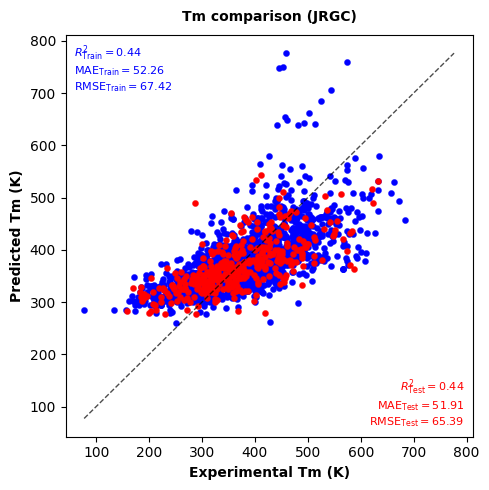


Statistical Comparison:
Metric          Train           Test            Difference     
----------------------------------------------------------------------
R2              0.4415          0.4445                  -0.0030
MAE             52.2640         51.9081                 -0.3559
RMSE            67.4169         65.3875                 -2.0294
MAPE            14.9013         15.4189                 +0.5177

Outliers identified:
Train: 78 (5.0%)
Test: 20 (5.2%)
Statistics appended to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Statistical comparison saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

SUMMARY
Train data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Tm.csv
Test data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Tm.csv
Statistics: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Train R²: 0.442
Test R²: 0.444

In [83]:
# Define your feature columns and target column
feature_columns = ['Mol. wt.', 'JR Tm /K']  # Replace with your actual feature column names
target_column = 'CRC Tm /K'  # Replace with your target property column name

# Run complete analysis
results = runCompleteTrainTestAnalysis(
    dataFrame=modified_Tm_CRC_dF,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2,
    random_state=42,
    property_description="Your Property Analysis",
    # CUSTOM LABELS AND TITLE
    x_label='Experimental Tm (K)',
    y_label='Predicted Tm (K)',
    plot_title='Tm comparison (JRGC)',

    outputDir='/content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/'
)

# Access results
trained_model = results['model']
train_performance = results['train_stats']
test_performance = results['test_stats']

# Check saved file paths
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
if results['file_paths']['train_csv']:
    print(f"Train data: {results['file_paths']['train_csv']}")
if results['file_paths']['test_csv']:
    print(f"Test data: {results['file_paths']['test_csv']}")
if results['file_paths']['stats_csv']:
    print(f"Statistics: {results['file_paths']['stats_csv']}")

print(f"\nTrain R²: {train_performance['R2']:.3f}")
print(f"Test R²: {test_performance['R2']:.3f}")
print(f"Overfitting (ΔR²): {train_performance['R2'] - test_performance['R2']:+.3f}")

### Critical Pressure Comparison [JR-predictions vs Experimental (CRC handbook)]

In [84]:
modified_Pc_CRC_dF

,CAS Reg. No.,PubChem SMILES,Mol. wt.,JR Pc /Bars,CRC Pc /Bars
0,583-58-4,CC1=C(C=NC=C1)C,107.156,40.414997,40.6
1,91-22-5,C1=CC=C2C(=C1)C=CC=N2,129.162,44.149623,47.5
2,107-15-3,C(CN)N,60.100,59.537418,67.1
3,929-06-6,C(COCCO)N,105.137,46.277014,48.8
4,877-43-0,CC1=CC2=C(C=C1)N=C(C=C2)C,157.216,33.528593,32.7
...,...,...,...,...,...
68,108-44-1,CC1=CC(=CC=C1)N,107.156,43.453908,46.0
69,353-85-5,C(#N)C(F)(F)F,95.023,41.569653,36.1
70,124-09-4,C(CCCN)CCN,116.208,35.430839,36.0
71,111-41-1,C(CNCCO)N,104.153,48.225309,45.3


In [85]:
modified_Pc_CRC_dF = modified_Pc_CRC_dF.sample(frac=1, random_state=42).reset_index(drop=True)

In [86]:
modified_Pc_CRC_dF

,CAS Reg. No.,PubChem SMILES,Mol. wt.,JR Pc /Bars,CRC Pc /Bars
0,877-43-0,CC1=CC2=C(C=C1)N=C(C=C2)C,157.216,33.528593,32.7
1,121-69-7,CN(C)C1=CC=CC=C1,121.183,36.421261,36.3
2,108-47-4,CC1=CC(=NC=C1)C,107.156,40.414997,38.3
3,583-58-4,CC1=C(C=NC=C1)C,107.156,40.414997,40.6
4,108-99-6,CC1=CN=CC=C1,93.129,46.784851,46.3
...,...,...,...,...,...
68,123-75-1,C1CCNC1,71.123,53.749108,56.9
69,110-89-4,C1CCNCC1,85.150,48.561959,47.0
70,90-41-5,C1=CC=C(C=C1)C2=CC=CC=C2N,169.227,36.028817,35.2
71,311-89-7,C(C(C(F)(F)F)(F)F)(C(N(C(C(C(C(F)(F)F)(F)F)(F)...,671.085,8.862985,12.4


Complete Train-Test Analysis: Your Property Analysis
DataFrame shape: (73, 5)
Target column: CRC Pc /Bars
Feature columns: ['Mol. wt.', 'JR Pc /Bars']

Data split completed:
Total valid samples: 73
Training samples: 58 (79.5%)
Test samples: 15 (20.5%)
--------------------------------------------------
Train dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Pc.csv
Test dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Pc.csv
--------------------------------------------------
Model trained on 58 samples
Features used: ['Mol. wt.', 'JR Pc /Bars']

GENERATING COMBINED TRAIN+TEST PLOT
Plotting Combined Train+Test: Pc
--------------------------------------------------
Plot saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Pc_combined.png and /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Pc_combined.svg


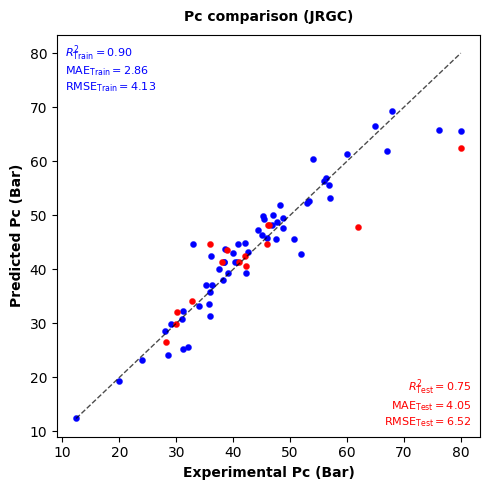


Statistical Comparison:
Metric          Train           Test            Difference     
----------------------------------------------------------------------
R2              0.8956          0.7465                  +0.1491
MAE             2.8573          4.0488                  +1.1914
RMSE            4.1262          6.5188                  +2.3927
MAPE            6.5217          8.1596                  +1.6378

Outliers identified:
Train: 3 (5.2%)
Test: 1 (6.7%)
Statistics appended to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Statistical comparison saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

SUMMARY
Train data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Pc.csv
Test data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Pc.csv
Statistics: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Train R²: 0.896
Test R²: 0.746
O

In [87]:
# Define your feature columns and target column
feature_columns = ['Mol. wt.', 'JR Pc /Bars']  # Replace with your actual feature column names
target_column = 'CRC Pc /Bars'  # Replace with your target property column name

# Run complete analysis
results = runCompleteTrainTestAnalysis(
    dataFrame=modified_Pc_CRC_dF,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2,
    random_state=42,
    property_description="Your Property Analysis",
    # CUSTOM LABELS AND TITLE
    x_label='Experimental Pc (Bar)',
    y_label='Predicted Pc (Bar)',
    plot_title='Pc comparison (JRGC)',

    outputDir='/content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/'
)

# Access results
trained_model = results['model']
train_performance = results['train_stats']
test_performance = results['test_stats']

# Check saved file paths
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
if results['file_paths']['train_csv']:
    print(f"Train data: {results['file_paths']['train_csv']}")
if results['file_paths']['test_csv']:
    print(f"Test data: {results['file_paths']['test_csv']}")
if results['file_paths']['stats_csv']:
    print(f"Statistics: {results['file_paths']['stats_csv']}")

print(f"\nTrain R²: {train_performance['R2']:.3f}")
print(f"Test R²: {test_performance['R2']:.3f}")
print(f"Overfitting (ΔR²): {train_performance['R2'] - test_performance['R2']:+.3f}")

### Critical Volume Comparison [JR-predictions vs Experimental (CRC handbook)]

In [88]:
modified_Vc_CRC_dF.columns

Index(['CAS Reg. No.', 'PubChem SMILES', 'Mol. wt.', 'JR Vc /(cm3 mol-1)',
       'CRC Vc /(cm3 mol-1)'],
      dtype='object')

Complete Train-Test Analysis: Your Property Analysis
DataFrame shape: (69, 5)
Target column: CRC Vc /(cm3 mol-1)
Feature columns: ['Mol. wt.', 'JR Vc /(cm3 mol-1)']

Data split completed:
Total valid samples: 69
Training samples: 55 (79.7%)
Test samples: 14 (20.3%)
--------------------------------------------------
Train dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Vc.csv
Test dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Vc.csv
--------------------------------------------------
Model trained on 55 samples
Features used: ['Mol. wt.', 'JR Vc /(cm3 mol-1)']

GENERATING COMBINED TRAIN+TEST PLOT
Plotting Combined Train+Test: Vc
--------------------------------------------------
Plot saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Vc_combined.png and /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Vc_combined.svg


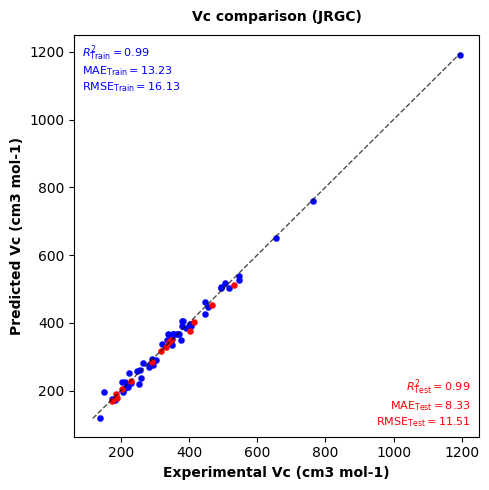


Statistical Comparison:
Metric          Train           Test            Difference     
----------------------------------------------------------------------
R2              0.9907          0.9886                  +0.0021
MAE             13.2333         8.3349                  -4.8984
RMSE            16.1347         11.5085                 -4.6261
MAPE            4.6166          2.4489                  -2.1677

Outliers identified:
Train: 3 (5.5%)
Test: 1 (7.1%)
Statistics appended to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Statistical comparison saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

SUMMARY
Train data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Vc.csv
Test data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Vc.csv
Statistics: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Train R²: 0.991
Test R²: 0.989
O

In [89]:
# Define your feature columns and target column
feature_columns = ['Mol. wt.', 'JR Vc /(cm3 mol-1)']  # Replace with your actual feature column names
target_column = 'CRC Vc /(cm3 mol-1)'  # Replace with your target property column name

# Run complete analysis
results = runCompleteTrainTestAnalysis(
    dataFrame=modified_Vc_CRC_dF,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2,
    random_state=42,
    property_description="Your Property Analysis",

    # CUSTOM LABELS AND TITLE
    x_label='Experimental Vc (cm3 mol-1)',
    y_label='Predicted Vc (cm3 mol-1)',
    plot_title='Vc comparison (JRGC)',

    outputDir='/content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/'
)

# Access results
trained_model = results['model']
train_performance = results['train_stats']
test_performance = results['test_stats']

# Check saved file paths
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
if results['file_paths']['train_csv']:
    print(f"Train data: {results['file_paths']['train_csv']}")
if results['file_paths']['test_csv']:
    print(f"Test data: {results['file_paths']['test_csv']}")
if results['file_paths']['stats_csv']:
    print(f"Statistics: {results['file_paths']['stats_csv']}")

print(f"\nTrain R²: {train_performance['R2']:.3f}")
print(f"Test R²: {test_performance['R2']:.3f}")
print(f"Overfitting (ΔR²): {train_performance['R2'] - test_performance['R2']:+.3f}")

### Critical Temparature Comparison [JR-predictions vs Experimental (CRC handbook)]

In [90]:
modified_Tc_CRC_dF.columns

Index(['CAS Reg. No.', 'PubChem SMILES', 'Mol. wt.', 'JR Tc /K', 'CRC Tc /K'], dtype='object')

Complete Train-Test Analysis: Your Property Analysis
DataFrame shape: (73, 5)
Target column: CRC Tc /K
Feature columns: ['Mol. wt.', 'JR Tc /K']

Data split completed:
Total valid samples: 73
Training samples: 58 (79.5%)
Test samples: 15 (20.5%)
--------------------------------------------------
Train dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Tc.csv
Test dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Tc.csv
--------------------------------------------------
Model trained on 58 samples
Features used: ['Mol. wt.', 'JR Tc /K']

GENERATING COMBINED TRAIN+TEST PLOT
Plotting Combined Train+Test: Tc
--------------------------------------------------
Plot saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Tc_combined.png and /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Tc_combined.svg


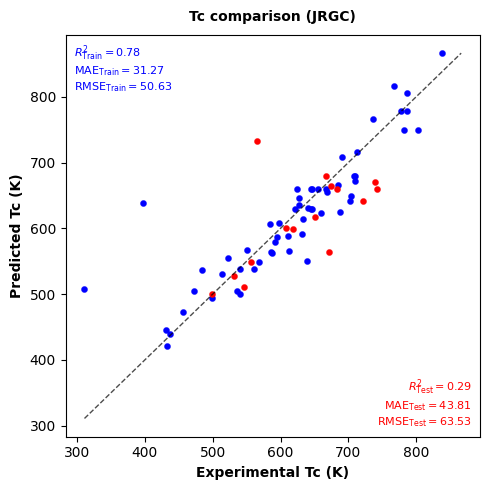


Statistical Comparison:
Metric          Train           Test            Difference     
----------------------------------------------------------------------
R2              0.7820          0.2888                  +0.4932
MAE             31.2730         43.8084                +12.5354
RMSE            50.6289         63.5317                +12.9028
MAPE            5.9158          6.7815                  +0.8656

Outliers identified:
Train: 3 (5.2%)
Test: 1 (6.7%)
Statistics appended to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Statistical comparison saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

SUMMARY
Train data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Tc.csv
Test data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Tc.csv
Statistics: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Train R²: 0.782
Test R²: 0.289
O

In [91]:
# Define your feature columns and target column
feature_columns = ['Mol. wt.', 'JR Tc /K']  # Replace with your actual feature column names
target_column = 'CRC Tc /K'  # Replace with your target property column name

# Run complete analysis
results = runCompleteTrainTestAnalysis(
    dataFrame=modified_Tc_CRC_dF,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2,
    random_state=42,
    property_description="Your Property Analysis",

    # CUSTOM LABELS AND TITLE
    x_label='Experimental Tc (K)',
    y_label='Predicted Tc (K)',
    plot_title='Tc comparison (JRGC)',

    outputDir='/content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/'
)

# Access results
trained_model = results['model']
train_performance = results['train_stats']
test_performance = results['test_stats']

# Check saved file paths
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
if results['file_paths']['train_csv']:
    print(f"Train data: {results['file_paths']['train_csv']}")
if results['file_paths']['test_csv']:
    print(f"Test data: {results['file_paths']['test_csv']}")
if results['file_paths']['stats_csv']:
    print(f"Statistics: {results['file_paths']['stats_csv']}")

print(f"\nTrain R²: {train_performance['R2']:.3f}")
print(f"Test R²: {test_performance['R2']:.3f}")
print(f"Overfitting (ΔR²): {train_performance['R2'] - test_performance['R2']:+.3f}")

### Enthalpy of Vaporisation [JR-predictions vs Experimental (CRC handbook)]

In [92]:
modified_Hvap_CRC_dF

,CAS Reg. No.,PubChem SMILES,Mol. Wt.,JR Hvap /kJ mol-1,CRC Hvap /kJ mol-1
0,311-89-7,C(C(C(F)(F)F)(F)F)(C(N(C(C(C(C(F)(F)F)(F)F)(F)...,671.085,6.738,46.40
1,108-03-2,CCC[N+](=O)[O-],89.094,38.863,38.50
2,583-58-4,CC1=C(C=NC=C1)C,107.156,40.324,39.99
3,4747-21-1,CC(C)NC,73.139,30.546,28.71
4,110-91-8,C1COCCN1,87.122,36.504,37.10
...,...,...,...,...,...
70,108-18-9,CC(C)NC(C)C,101.193,34.610,30.40
71,630-18-2,CC(C)(C)C#N,83.134,35.906,32.40
72,121-44-8,CCN(CC)CC,101.193,30.993,31.01
73,109-97-7,C1=CNC=C1,67.091,32.406,38.75


In [93]:
modified_Hvap_CRC_dF = modified_Hvap_CRC_dF.sample(frac=1, random_state=42).reset_index(drop=True)

In [94]:
modified_Hvap_CRC_dF.columns

Index(['CAS Reg. No.', 'PubChem SMILES', 'Mol. Wt.', 'JR Hvap /kJ mol-1',
       'CRC Hvap /kJ mol-1'],
      dtype='object')

In [95]:
modified_Hvap_CRC_dF = modified_Hvap_CRC_dF.rename(columns={'JR Hvap /(kJ mol-1)': 'JR Hvap /kJ mol-1', 'CRC Hvap /(kJ mol-1)': 'CRC Hvap /kJ mol-1'})
modified_Hvap_CRC_dF

,CAS Reg. No.,PubChem SMILES,Mol. Wt.,JR Hvap /kJ mol-1,CRC Hvap /kJ mol-1
0,110-91-8,C1COCCN1,87.122,36.504,37.10
1,108-48-5,CC1=NC(=CC=C1)C,107.156,40.324,37.46
2,104-75-6,CCCCC(CC)CN,129.247,43.655,40.00
3,311-89-7,C(C(C(F)(F)F)(F)F)(C(N(C(C(C(C(F)(F)F)(F)F)(F)...,671.085,6.738,46.40
4,108-44-1,CC1=CC(=CC=C1)N,107.156,44.755,44.90
...,...,...,...,...,...
70,78-81-9,CC(C)CN,73.139,34.751,30.61
71,74-89-5,CN,31.058,28.461,25.60
72,630-18-2,CC(C)(C)C#N,83.134,35.906,32.40
73,141-43-5,C(CO)N,61.084,47.366,49.83


Complete Train-Test Analysis: Your Property Analysis
DataFrame shape: (75, 5)
Target column: CRC Hvap /kJ mol-1
Feature columns: ['Mol. Wt.', 'JR Hvap /kJ mol-1']

Data split completed:
Total valid samples: 75
Training samples: 60 (80.0%)
Test samples: 15 (20.0%)
--------------------------------------------------
Train dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Hvap.csv
Test dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Hvap.csv
--------------------------------------------------
Model trained on 60 samples
Features used: ['Mol. Wt.', 'JR Hvap /kJ mol-1']

GENERATING COMBINED TRAIN+TEST PLOT
Plotting Combined Train+Test: Hvap
--------------------------------------------------
Plot saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Hvap_combined.png and /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_Hvap_combined.svg


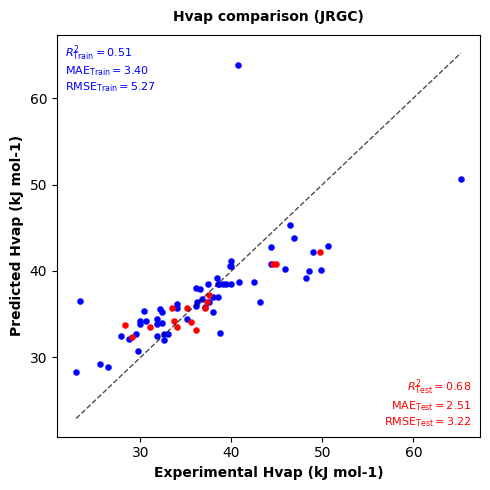


Statistical Comparison:
Metric          Train           Test            Difference     
----------------------------------------------------------------------
R2              0.5059          0.6847                  -0.1788
MAE             3.4048          2.5137                  -0.8911
RMSE            5.2682          3.2169                  -2.0513
MAPE            9.1829          6.8407                  -2.3423

Outliers identified:
Train: 3 (5.0%)
Test: 1 (6.7%)
Statistics appended to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Statistical comparison saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

SUMMARY
Train data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_Hvap.csv
Test data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_Hvap.csv
Statistics: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Train R²: 0.506
Test R²: 0.6

In [96]:
# Define your feature columns and target column
feature_columns = ['Mol. Wt.', 'JR Hvap /kJ mol-1']  # Replace with your actual feature column names
target_column = 'CRC Hvap /kJ mol-1'  # Replace with your target property column name

# Run complete analysis
results = runCompleteTrainTestAnalysis(
    dataFrame=modified_Hvap_CRC_dF,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2,
    random_state=42,
    property_description="Your Property Analysis",

    # CUSTOM LABELS AND TITLE
    x_label='Experimental Hvap (kJ mol-1)',
    y_label='Predicted Hvap (kJ mol-1)',
    plot_title='Hvap comparison (JRGC)',

    outputDir='/content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/'
)

# Access results
trained_model = results['model']
train_performance = results['train_stats']
test_performance = results['test_stats']

# Check saved file paths
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
if results['file_paths']['train_csv']:
    print(f"Train data: {results['file_paths']['train_csv']}")
if results['file_paths']['test_csv']:
    print(f"Test data: {results['file_paths']['test_csv']}")
if results['file_paths']['stats_csv']:
    print(f"Statistics: {results['file_paths']['stats_csv']}")

print(f"\nTrain R²: {train_performance['R2']:.3f}")
print(f"Test R²: {test_performance['R2']:.3f}")
print(f"Overfitting (ΔR²): {train_performance['R2'] - test_performance['R2']:+.3f}")

### logP [JR-predictions vs Experimental (CRC handbook)]



In [97]:
modified_logP_CRC_dF.columns

Index(['CAS Reg. No.', 'PubChem SMILES', 'Mol. wt.', 'Log P (JR)',
       'logP (CRC)'],
      dtype='object')

Complete Train-Test Analysis: logP
DataFrame shape: (3463, 5)
Target column: logP (CRC)
Feature columns: ['Mol. wt.', 'Log P (JR)']

Data split completed:
Total valid samples: 3463
Training samples: 2770 (80.0%)
Test samples: 693 (20.0%)
--------------------------------------------------
Train dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_(CRC).csv
Test dataset saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_(CRC).csv
--------------------------------------------------
Model trained on 2770 samples
Features used: ['Mol. wt.', 'Log P (JR)']

GENERATING COMBINED TRAIN+TEST PLOT
Plotting Combined Train+Test: (CRC)
--------------------------------------------------


/tmp/ipython-input-3004091262.py:128: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((exp_data - pred_data) / exp_data)) * 100
/tmp/ipython-input-3004091262.py:128: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((exp_data - pred_data) / exp_data)) * 100


Plot saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_(CRC)_combined.png and /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/parity_plot_(CRC)_combined.svg


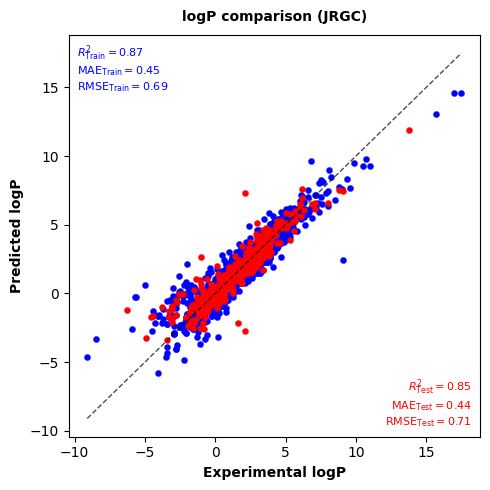


Statistical Comparison:
Metric          Train           Test            Difference     
----------------------------------------------------------------------
R2              0.8724          0.8529                  +0.0195
MAE             0.4543          0.4442                  -0.0101
RMSE            0.6949          0.7134                  +0.0184
MAPE            inf             inf                        +nan

Outliers identified:
Train: 139 (5.0%)
Test: 35 (5.1%)
Statistics appended to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Statistical comparison saved to: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

SUMMARY
Train data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_train_(CRC).csv
Test data: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/JRGC_test_(CRC).csv
Statistics: /content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/statistical_comparison.csv

Train R²: 0.872
Test R²

/tmp/ipython-input-3004091262.py:323: RuntimeWarning: invalid value encountered in scalar subtract
  diff = test_val - train_val


In [98]:
# Define your feature columns and target column
feature_columns = ['Mol. wt.', 'Log P (JR)']  # Replace with your actual feature column names
target_column = 'logP (CRC)'  # Replace with your target property column name

# Run complete analysis
results = runCompleteTrainTestAnalysis(
    dataFrame=modified_logP_CRC_dF,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2,
    random_state=42,
    property_description="logP",

    # CUSTOM LABELS AND TITLE
    x_label='Experimental logP',
    y_label='Predicted logP',
    plot_title='logP comparison (JRGC)',

    outputDir='/content/drive/Shareddrives/GCCP/GCCP/Output_files/JRGC/'
)

# Access results
trained_model = results['model']
train_performance = results['train_stats']
test_performance = results['test_stats']

# Check saved file paths
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
if results['file_paths']['train_csv']:
    print(f"Train data: {results['file_paths']['train_csv']}")
if results['file_paths']['test_csv']:
    print(f"Test data: {results['file_paths']['test_csv']}")
if results['file_paths']['stats_csv']:
    print(f"Statistics: {results['file_paths']['stats_csv']}")

print(f"\nTrain R²: {train_performance['R2']:.3f}")
print(f"Test R²: {test_performance['R2']:.3f}")
print(f"Overfitting (ΔR²): {train_performance['R2'] - test_performance['R2']:+.3f}")